In [39]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
# from google.colab import files 
# uploaded = files.upload()

header = ['user_id','item_id','rating','timestamp']
dataset = pd.read_csv('./data/movies/ml-100k/u.data',sep = '\t',names = header)
dataset

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [16]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [17]:
train.head()

,user_id,item_id,rating,timestamp
75220,807,1411,1,893082619
48955,474,659,5,887925187
44966,463,268,4,877384940
13568,139,286,4,879537844
92727,621,751,4,883799651


In [18]:
test.head()

,user_id,item_id,rating,timestamp
75721,877,381,4,882677345
80184,815,602,3,878694269
19864,94,431,4,891721716
76699,416,875,2,876696938
92991,500,182,2,883873556


In [31]:
n_users = len(dataset.user_id.unique())
n_users

943

In [32]:
n_items = len(dataset.item_id.unique())
n_items

1682

In [33]:
# creating book embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_items+1, 5, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Books")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([movie_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, movie_input], out)
model2.compile('adam', 'mean_squared_error')

In [34]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Movie-Input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 User-Input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 5)                 8415      ['Movie-Input[0][0]']         
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 5)                 4720      ['User-Input[0][0]']    

In [35]:
history = model2.fit([train.user_id, train.item_id], train.rating, epochs=5, verbose=1)

Epoch 1/5
2500/2500 [==============================] - 18s 7ms/step - loss: 1.1513
Epoch 2/5
2500/2500 [==============================] - 16s 7ms/step - loss: 0.8910
Epoch 3/5
2500/2500 [==============================] - 16s 6ms/step - loss: 0.8646
Epoch 4/5
2500/2500 [==============================] - 15s 6ms/step - loss: 0.8455
Epoch 5/5
2500/2500 [==============================] - 14s 6ms/step - loss: 0.8319


Text(0, 0.5, 'Training Error')

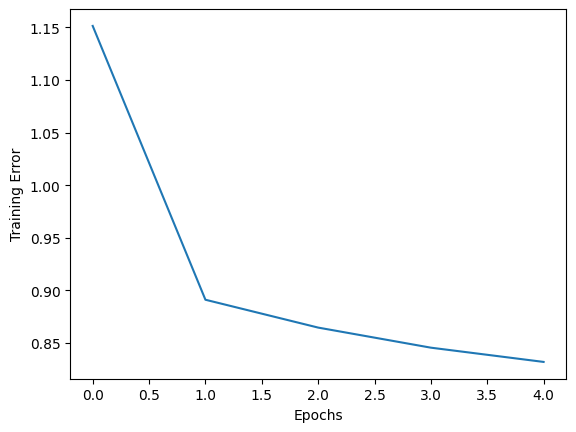

In [40]:
model2.save('./models/regression_model2.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [41]:
predictions = model2.predict([test.user_id.head(10), test.item_id.head(10)])
[print(predictions[i], test.rating.iloc[i]) for i in range(0,10)]

1/1 [==============================] - 0s 69ms/step
[3.608398] 4
[3.8282123] 3
[3.7009692] 4
[3.0789092] 2
[3.91226] 2
[3.1746159] 3
[3.9015546] 5
[3.7569916] 4
[3.4445853] 3
[3.0843534] 4


[None, None, None, None, None, None, None, None, None, None]

In [48]:
# Extract embeddings
movie_em = model2.get_layer('Movie-Embedding')
movie_em_weights = movie_em.get_weights()[0]

In [49]:
movie_em_weights.shape

(1683, 5)

<Axes: >

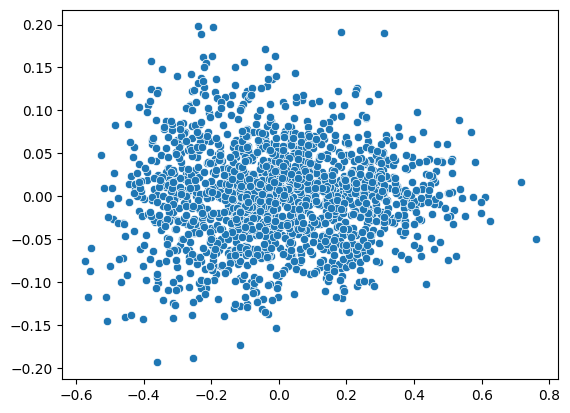

In [52]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_result = pca.fit_transform(movie_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [59]:
# Creating dataset for making recommendations for the first user
movie_data = np.array(list(set(dataset.item_id)))
movie_data[:5]

array([1, 2, 3, 4, 5])

In [73]:
user = np.array([1 for i in range(len(movie_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [74]:
predictions = model2.predict([pd.Series(user), pd.Series(movie_data)])

53/53 [==============================] - 1s 9ms/step


In [75]:
predictions

array([[3.9372332],
       [2.9445782],
       [2.8608055],
       ...,
       [1.7386227],
       [3.352323 ],
       [3.2662342]], dtype=float32)

In [76]:
predictions = np.array([a[0] for a in predictions])

recommended_movie_ids = (-predictions).argsort()[:5]

recommended_movie_ids

array([1448,  482,   63,  113,  317])